# Isolation Forest

Anomalies are more susceptible to
isolation and hence have short path lengths.
Given a Gaussian distribution (135 points),
(a) a normal point xi requires twelve random
partitions to be isolated; (b) an anomaly xo requires only four partitions to be isolated. (c)
averaged path lengths of xi and xo converge
when the number of trees increases.

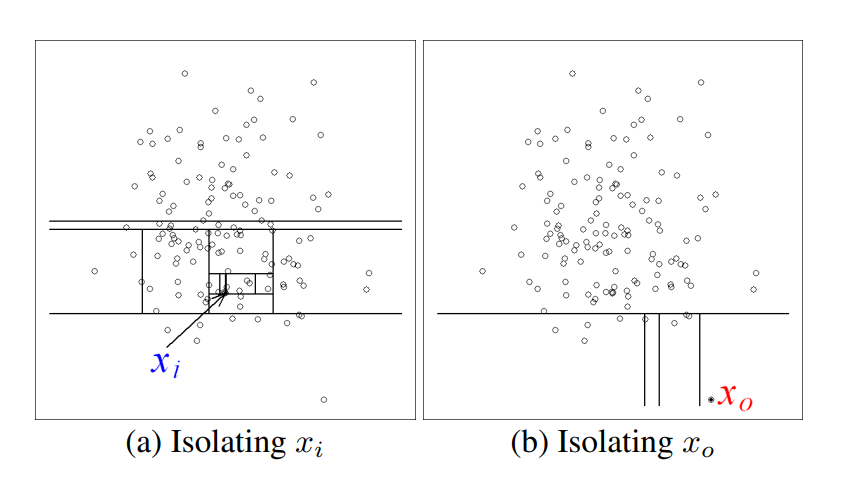

Using 1000 trees, the average path lengths of xo
and xi converge to 4.02 and 12.82 respectively. It shows
that anomalies are having path lengths shorter than normal
instances

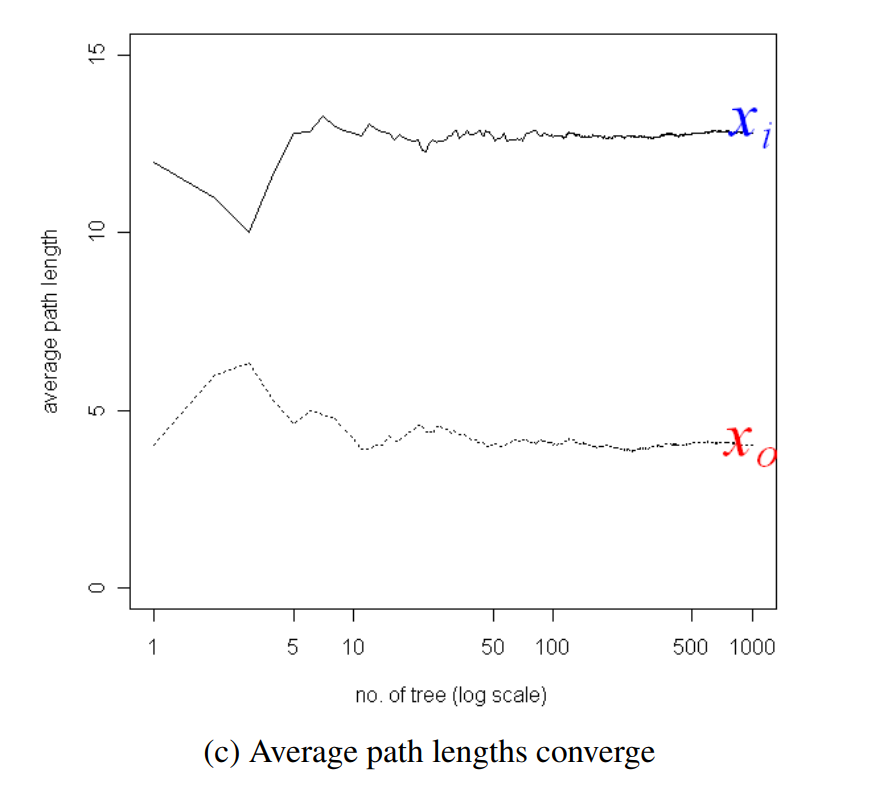

# Libraries

In [1054]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans



# functions

In [1055]:
# functions:

def remove_columns(df, cols):
  """
  This function removes columns from a pandas dataframe.

  Args:
      df: The pandas dataframe to remove columns from.
      cols: A list of column names to remove.

  Returns:
      A new pandas dataframe with the specified columns removed.
  """
  return df[list(set(df.columns) - set(cols))]





def scale_dataframe(df):
    """
    Scale the numerical columns of a DataFrame using Min-Max scaling.
    
    Parameters:
    df (DataFrame): Input DataFrame to be scaled.
    
    Returns:
    DataFrame: Scaled DataFrame.
    """
    # Copy the original DataFrame to avoid modifying the original data
    scaled_df = df.copy()
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Select only numerical columns
    numerical_columns = scaled_df.select_dtypes(include=['number']).columns
    
    # Scale numerical columns
    scaled_df[numerical_columns] = scaler.fit_transform(scaled_df[numerical_columns])
    
    return scaled_df






def scale_column(df, column_name):
    """
    Scale a single column of a DataFrame using Min-Max scaling.
    
    Parameters:
    df (DataFrame): Input DataFrame.
    column_name (str): Name of the column to scale.
    
    Returns:
    list: List of scaled values.
    """
    # Extract the specified column
    column_values = df[column_name].values.reshape(-1, 1)
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the column
    scaled_column_values = scaler.fit_transform(column_values)
    
    # Flatten the scaled values
    scaled_column_values = scaled_column_values.flatten()
    
    return scaled_column_values





def calculate_wcss(data):
    wcss = []
    for n_clusters in range(1, 11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=42)
        kmeans.fit(data.reshape(-1, 1))  # Reshape data to fit KMeans input format
        wcss.append(kmeans.inertia_)
    return wcss


# Sintetic data

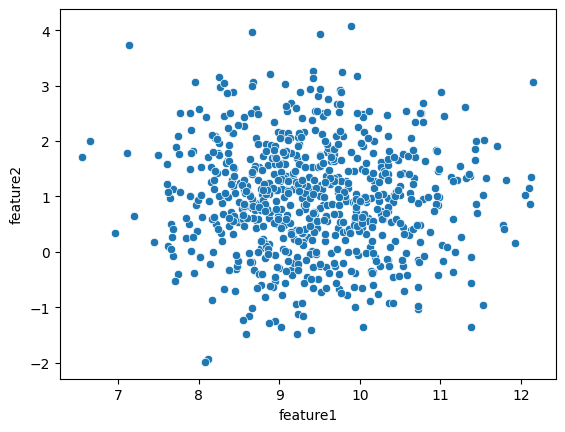

In [1056]:
X, y = make_blobs(n_samples=700, 
                  n_features=2,
                  centers=1,
                  cluster_std=1,
                  random_state=4   
                )
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1] })
sns.scatterplot(data=df, x="feature1", y="feature2")
plt.show()

In [1057]:
df

,feature1,feature2
0,10.171043,1.276023
1,8.536107,0.777192
2,9.724446,0.422714
3,8.688757,1.478298
4,8.937727,1.402551
...,...,...
695,8.386344,2.500617
696,10.719016,-0.985150
697,9.195350,1.452718
698,8.230171,2.035682


# descriptive analysis

In [1058]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature1,700.0,9.411384,0.955847,6.552688,8.743283,9.354551,10.051824,12.153472
feature2,700.0,0.965603,1.001734,-1.987272,0.326398,0.999505,1.634605,4.078683


graficas de las variables continuas 

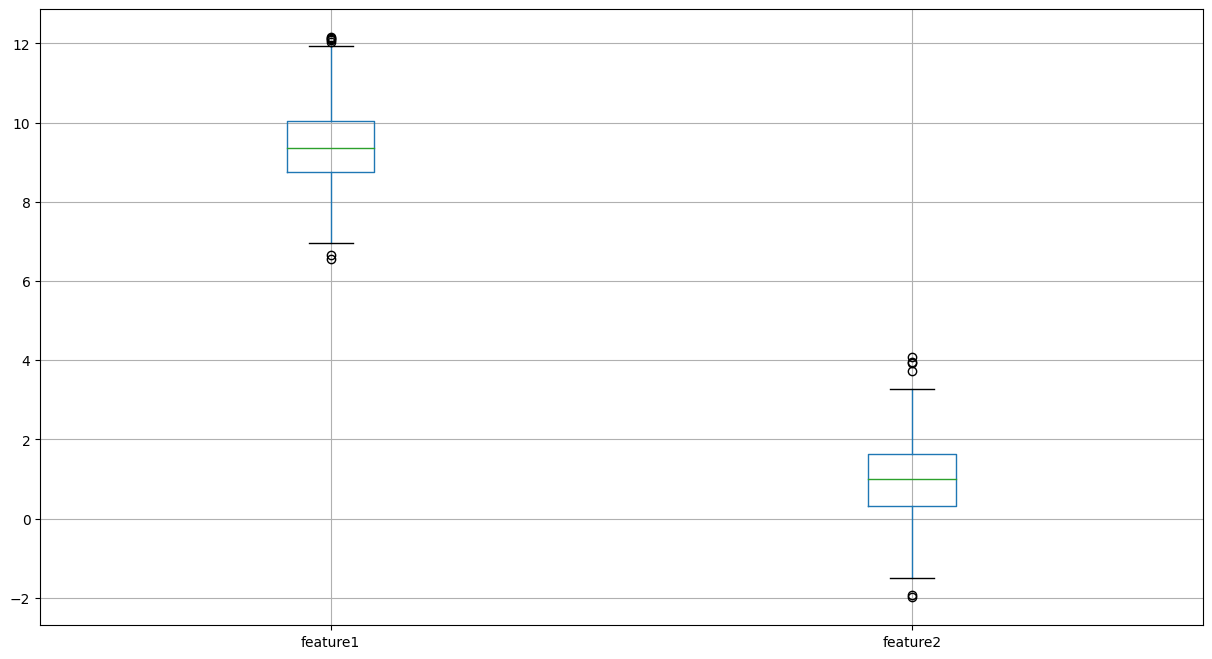

In [1059]:
df.boxplot(figsize=(15,8))
plt.show()


In [1060]:
scaled_df=scale_dataframe(df)
scaled_df

,feature1,feature2
0,0.646044,0.537969
1,0.354132,0.455734
2,0.566306,0.397297
3,0.381387,0.571315
4,0.425840,0.558828
...,...,...
695,0.327393,0.739849
696,0.743883,0.165204
697,0.471838,0.567098
698,0.299509,0.663202


## Train

In [1061]:
clf = IsolationForest(n_estimators=100,
                      max_samples=256,
                      contamination=0.05,
                      max_features=2,
                      bootstrap=True,
                      n_jobs=-1,
                      warm_start=False
                      
                      ).fit(scaled_df)

In [1062]:
scored=clf.score_samples(scaled_df)
label=clf.predict(scaled_df)

In [1063]:
new_df2=df.copy()

In [1064]:
new_df2['scored']=scored
new_df2['label']=label
new_df2['label']=np.where(new_df2['label']==-1,1,0)
new_df2

,feature1,feature2,scored,label
0,10.171043,1.276023,-0.449369,0
1,8.536107,0.777192,-0.425651,0
2,9.724446,0.422714,-0.438054,0
3,8.688757,1.478298,-0.436252,0
4,8.937727,1.402551,-0.426466,0
...,...,...,...,...
695,8.386344,2.500617,-0.521887,0
696,10.719016,-0.985150,-0.592878,0
697,9.195350,1.452718,-0.428836,0
698,8.230171,2.035682,-0.501091,0


## Find the best number of cluster

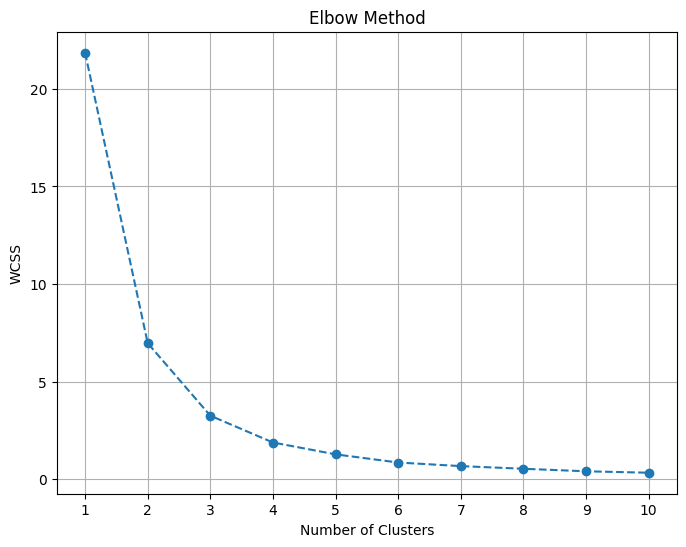

In [1065]:
score_scaled=scale_column(new_df2,'scored')
wcss_values = calculate_wcss(score_scaled)
# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# train cluster kmean

In [1066]:
# Train KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,n_init=10)
kmeans.fit(score_scaled.reshape(-1,1))

# Predict clusters for the data points
labels = kmeans.labels_

## Assign cluters to original dataframe

In [1067]:
new_df2['cluster']=labels
new_df2

,feature1,feature2,scored,label,cluster
0,10.171043,1.276023,-0.449369,0,0
1,8.536107,0.777192,-0.425651,0,0
2,9.724446,0.422714,-0.438054,0,0
3,8.688757,1.478298,-0.436252,0,0
4,8.937727,1.402551,-0.426466,0,0
...,...,...,...,...,...
695,8.386344,2.500617,-0.521887,0,1
696,10.719016,-0.985150,-0.592878,0,2
697,9.195350,1.452718,-0.428836,0,0
698,8.230171,2.035682,-0.501091,0,1


# result

The score is very useful to identify anomalies with hight, medium or low probability

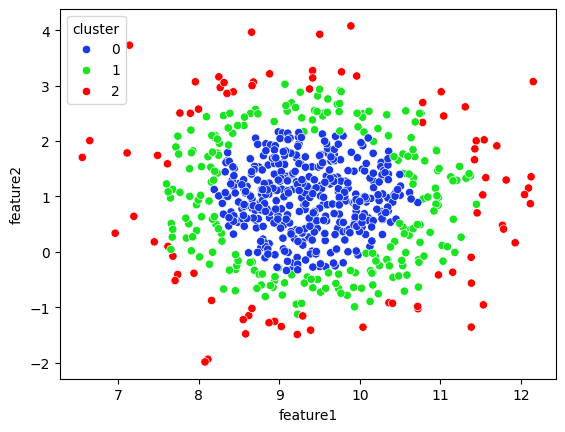

In [1069]:
custom_palette = ["#1937e4", "#19e420", "#FF0000"]
sns.scatterplot(data=new_df2, x="feature1", y="feature2",hue="cluster",palette=custom_palette)
plt.show()

# Conclusion

* The parameter contamination=0.05 doest'n matter if we only use the score instead of label

* the paramer max_samples=n, is strongly recommended to avoid swamping and masking.

* This algorithm performs well in High-dimensional data

